In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install livelossplot

## Les librairies


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import livelossplot
import cv2
import numpy as np
import joblib
import tensorflow as tf
import imghdr

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import regularizers
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from PIL import Image
from sklearn import preprocessing

c:\Environnement\windows_env\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Les fonctions


In [ ]:
# # Prétraitement de l'image : redimensionnemennt et standardisation

def preprocess_img(img, new_size=(240, 320)):
    """
    Redimensionne et normalise une image.

    Args:
        img (numpy.ndarray): L'image à traiter.
        new_size (tuple): La nouvelle taille de l'image. Par défaut (240, 320).

    Returns:
        numpy.ndarray: L'image redimensionnée et normalisée.
    """
    if img is None:
        raise ValueError("Aucune image n'a été fournie.")

    resized_img = cv2.resize(img, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # Normalisation en divisant par 255
    normalized_img = resized_img / 255.0
    return normalized_img

## Récupération des images et préparation de la dataset

In [ ]:
# Chemin vers le dossier principal contenant les sous-dossiers
# main_folder = '/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/datas/MMU-Iris-Database_2024_clean'
main_folder = 'C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/datas/MMU-Iris-Database_2024_clean'

# Dimensions de l'image
img_dim = (240, 320, 3)  # (hauteur, largeur, canaux de couleur)

In [ ]:
# Listes pour stocker les données de chaque côté ('left' et 'right')
X_left, X_right = [], []
Y_left, Y_right = [], []
X_GOD, Y_GOD = [], []

# # Parcours des dossiers dans le dossier principal
#     # Vérification si le chemin est un dossier
#         # Boucle sur les côtés 'left' et 'right'
#             # Vérification si le chemin du côté est un dossier
#                 # Parcours des fichiers dans le dossier du côté
#                     # Vérification si le fichier est une image
#                         # Récupération de la cible et prétraitement de l'image
#                         # Ajout de l'image et de la cible aux données correspondantes
#                         # Ajout de l'image et de la cible aux données combinées

for target_folder in os.listdir(main_folder):
    target_path = os.path.join(main_folder, target_folder)

    if os.path.isdir(target_path):
        for side in ['left', 'right']:
            side_path = os.path.join(target_path, side)

            if os.path.isdir(side_path):
                for image_filename in os.listdir(side_path):
                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image_save = preprocess_img(cv2.imread(image_path), img_dim)
                        X_side = X_left if side == 'left' else X_right
                        Y_side = Y_left if side == 'left' else Y_right
                        X_side.append(image_save)
                        Y_side.append(target)
                        X_GOD.append(image_save)
                        Y_GOD.append(1 if side == 'left' else 0)

In [ ]:
# Affichage du nombre d'éléments dans les listes X_left et Y_left
print(len(X_left), len(Y_left))

# Affichage du nombre d'éléments dans les listes X_right et Y_right
print(len(X_right), len(Y_right))

# Affichage du nombre d'éléments dans les listes combinées X_r_or_l et Y_r_or_l
print(len(X_GOD), len(Y_GOD))


225 225
225 225
450 450


---
---
## Entrainement du modèle et affichage des performances

In [ ]:
# # Arrêt anticipé et Réduction de de descente de gradient
# rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
# early = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

# Importation des modules nécessaires pour l'arrêt anticipé et la réduction de taux d'apprentissage
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback pour réduire le taux d'apprentissage lorsque la performance stagne
rlrop = ReduceLROnPlateau(
    monitor='val_loss',  # Métrique à surveiller
    factor=0.1,           # Facteur de réduction du taux d'apprentissage
    patience=2           # Nombre d'époques sans amélioration avant la réduction
)

# Callback pour arrêter l'entraînement si la performance ne s'améliore plus
early = EarlyStopping(
    monitor='val_loss',         # Métrique à surveiller
    patience=4,                 # Nombre d'époques sans amélioration avant l'arrêt
    restore_best_weights=True  # Restaurer les meilleurs poids du modèle
)


In [ ]:
# Nombre de classes dans votre problème
NBCLASSES = 45
# Taille de l'image en entrée du modèle
IMSIZE = [240, 320]

def create_model():
    # Charger le modèle VGG16 pré-entraîné sur ImageNet
    vgg = VGG16(input_shape=IMSIZE + [3], weights='imagenet', include_top=False)

    # Geler les poids des couches du modèle VGG16 pré-entraîné
    for layer in vgg.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle VGG16
    out = vgg.output

    # Ajouter une nouvelle couche dense à la fin du modèle
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)

    # Créer un nouveau modèle avec l'entrée de VGG16 et la sortie de la nouvelle couche dense
    model = Model(inputs=vgg.input, outputs=x)

    # Compiler le modèle avec la fonction de perte, l'optimiseur et les métriques spécifiés
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

    # Afficher un résumé du modèle
    model.summary()

    return model

In [ ]:
# Création d'un générateur d'images avec des transformations aléatoires
datagen = ImageDataGenerator(
    rotation_range=10,          # Angle de rotation aléatoire dans la plage de [-10, 10] degrés
    zoom_range=0.1,             # Zoom aléatoire dans la plage de [0.9, 1.1]
    brightness_range=(0.8, 1.2) # Variation aléatoire de la luminosité dans la plage de [0.8, 1.2]
)

def data_aug(data_x, data_y, multiplicateur):
    # Initialisation des listes pour stocker les données augmentées
    aug_x = []
    aug_y = []

    # Parcours des données d'entrée
    for i in range(len(data_x)):
        x = image.img_to_array(data_x[i])  # Convertit l'image en tableau numpy
        x = x * 255                         # Remet à l'échelle des pixels de [0, 1] à [0, 255]
        x = np.expand_dims(x, axis=0)      # Ajoute une dimension pour créer un lot d'une seule image

        count = 0  # Compteur pour limiter le nombre d'images augmentées
        for batch in datagen.flow(x, batch_size=1):
            aug_x.append(batch[0] / 255)  # Remet à l'échelle des pixels de [0, 255] à [0, 1]
            aug_y.append(data_y[i])       # Ajoute l'étiquette de la donnée d'origine

            count += 1
            if count >= multiplicateur:   # Arrête lorsque le nombre d'images augmentées atteint le multiplicateur
                break

    return aug_x, aug_y

---
## OEIL GAUCHE OU DROIT ?

In [ ]:
# Création d'un encodeur de labels pour les données de gauche
labelEnc_GOD = preprocessing.LabelEncoder()

# Encodage des étiquettes Y_left
Y_enc_GOD = labelEnc_GOD.fit_transform(Y_GOD)

# Sauvegarde de l'encodeur de labels dans un fichier joblib
# joblib.dump(labelEnc_GOD, '/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/joblib_encodage/encodage_GOD.joblib')
joblib.dump(labelEnc_GOD, 'C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/joblib_encodage/encodage_GOD.joblib')



['C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/joblib_encodage/encodage_GOD.joblib']

#### Split et sauvegarde de 2 images du groupe test


In [ ]:
# Séparation des données en ensembles d'entraînement et de test en maintenant la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(X_GOD, Y_enc_GOD, test_size=0.2, random_state=42, stratify=Y_enc_GOD)

# Boucle sur les dernières deux images du jeu de test pour les sauvegarder
for i in range(-3, -1):
    # Chemin de sortie pour sauvegarder l'image prétraitée
    # output_path = f'/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/train_save/id_{labelEnc_GOD.inverse_transform(y_test)[i]}_GOD.bmp'
    output_path = f'C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/train_save/id_{labelEnc_GOD.inverse_transform(y_test)[i]}_GOD.bmp'

    # Récupération de la dernière image prétraitée du jeu de test
    last_preprocessed_img = X_test[i]

    # Conversion de l'image prétraitée en image PIL
    im = Image.fromarray((last_preprocessed_img * 255).astype(np.uint8))

    # Sauvegarde de l'image
    im.save(output_path)

#### Visualisation des transformations sur la première image


In [ ]:
mult_aug_train = 5
mult_aug_test = 2

# Augmentation des données d'entraînement
aug_X_train, aug_y_train = data_aug(X_train, y_train, mult_aug_train)

# Augmentation des données de test
aug_X_test, aug_y_test = data_aug(X_test, y_test, mult_aug_test)

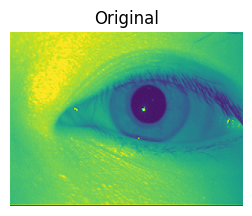

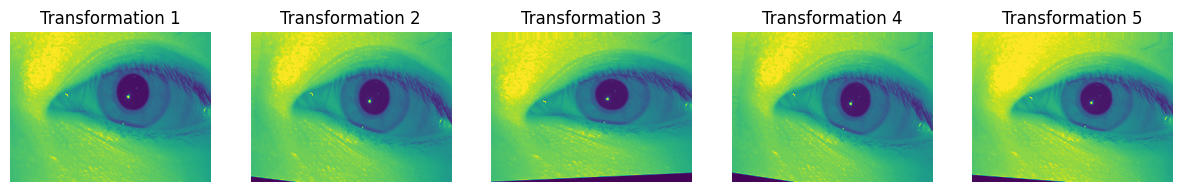

In [ ]:
# Affichage de l'image originale
plt.figure(figsize=(3, 5))
plt.imshow(X_train[0][:,:,2])  # Affiche le canal bleu de la première image d'entraînement
plt.title(f'Original')
plt.axis('off')  # Désactive les axes
plt.show()

# Affichage des images transformées
plt.figure(figsize=(15, 5))
for i in range(mult_aug_train):
    plt.subplot(1, mult_aug_train, i + 1)  # Crée une sous-trace pour chaque image transformée
    plt.imshow(aug_X_train[i][:,:,2])  # Affiche le canal bleu de l'image transformée
    plt.title(f'Transformation {i + 1}')
    plt.axis('off')  # Désactive les axes
plt.show()

In [ ]:
# Ajout des données augmentées à l'ensemble d'entraînement
X_train.extend(aug_X_train)
y_train = np.concatenate((y_train, np.array(aug_y_train)))

# Ajout des données augmentées à l'ensemble de test
X_test.extend(aug_X_test)
y_test = np.concatenate((y_test, np.array(aug_y_test)))

In [ ]:
# Conversion des étiquettes en encodage one-hot pour l'ensemble d'entraînement
y_train_enc = to_categorical(y_train)

# Conversion des étiquettes en encodage one-hot pour l'ensemble de test
y_test_enc = to_categorical(y_test)

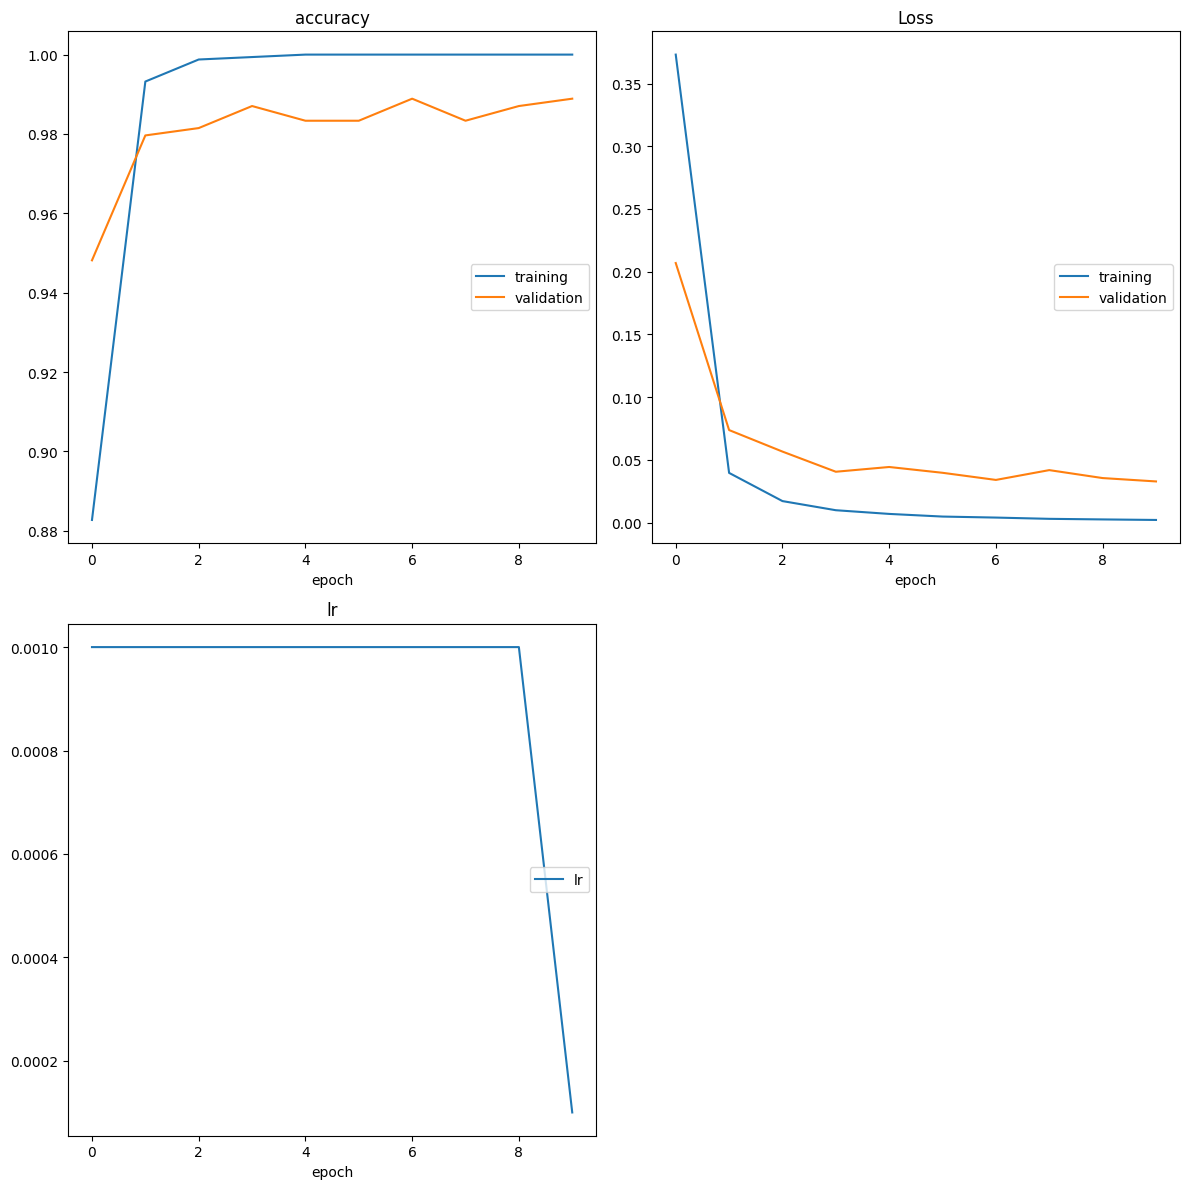

accuracy
	training         	 (min:    0.883, max:    1.000, cur:    1.000)
	validation       	 (min:    0.948, max:    0.989, cur:    0.989)
Loss
	training         	 (min:    0.002, max:    0.373, cur:    0.002)
	validation       	 (min:    0.033, max:    0.207, cur:    0.033)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
108/108 [==============================] - 852s 8s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0329 - val_accuracy: 0.9889 - lr: 1.0000e-04


In [ ]:
# Création du modèle
NBCLASSES = 2
GOD_model = create_model()

# Entraînement du modèle
hist = GOD_model.fit(
    np.array(X_train),            # Données d'entraînement
    np.array(y_train_enc),       # Étiquettes d'entraînement encodées en one-hot
    batch_size=15,               # Taille du lot
    epochs=10,                   # Nombre d'époques
    validation_split=0.25,       # Fraction des données à utiliser comme ensemble de validation
    callbacks=[rlrop, early, PlotLossesKeras()]     # Callbacks pour la réduction du taux d'apprentissage sur plateau et l'arrêt anticipé
)

In [ ]:
# Obtenir les prédictions du modèle sur les données de test
y_test_pred = [np.argmax(v) for v in GOD_model.predict(np.array(X_test))]

# Afficher le nombre total d'erreurs de classification
print(f"Nombre total d'erreurs de classification : {sum(y_test != y_test_pred)} sur {len(y_test)} exemples.")

9/9 [==============================] - 106s 12s/step
Nombre total d'erreurs de classification : 19 sur 270 exemples.


Matrice de confusion Matrice de Confusion Oeil Gauche ou Droit:
Précision : 0.93
Rappel : 0.93
Score F1 : 0.93
Exactitude : 0.93


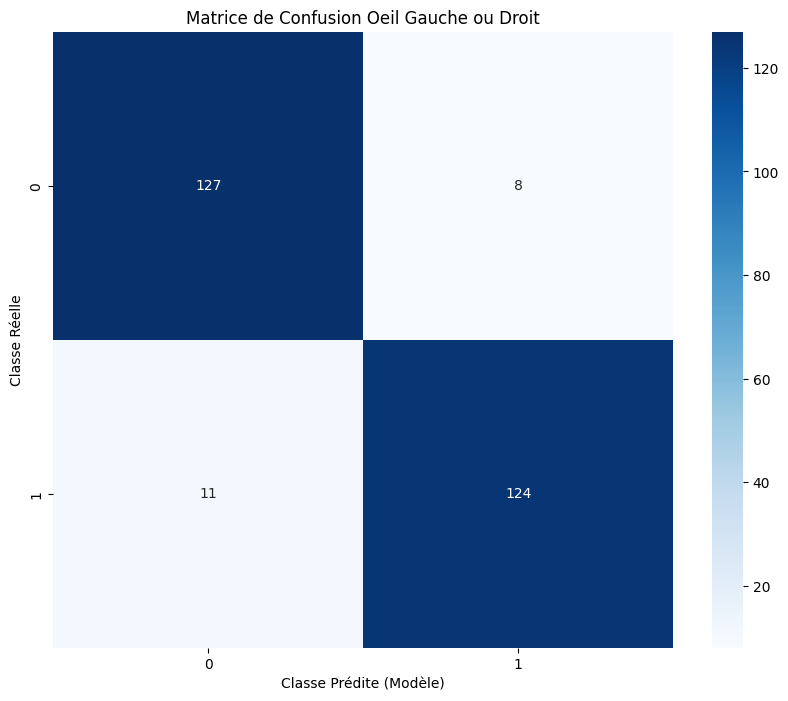

In [ ]:
def matrice(y_true, y_pred, titre):
    """
    Affiche la matrice de confusion et les mesures de performance pour les prédictions de classification.

    Args:
        y_true (array): Les vraies étiquettes de classe.
        y_pred (array): Les étiquettes de classe prédites par le modèle.
        titre (str): Le titre de la matrice de confusion.

    Returns:
        None
    """
    # Calcul de la matrice de confusion
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calcul des mesures de performance
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Affichage des mesures de performance
    print("Matrice de confusion " + titre + ":")
    print("Précision : {:.2f}".format(precision))
    print("Rappel : {:.2f}".format(recall))
    print("Score F1 : {:.2f}".format(f1))
    print("Exactitude : {:.2f}".format(accuracy))

    # Création de la figure pour la matrice de confusion
    plt.figure(figsize=(10, 8))

    # Utilisation de Seaborn pour rendre la matrice de confusion plus esthétique
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

    # Ajout des étiquettes et du titre
    plt.xlabel("Classe Prédite (Modèle)")
    plt.ylabel("Classe Réelle")
    plt.title(titre)

    # Affichage de la matrice de confusion
    plt.show()

matrice(y_test,y_test_pred,"Matrice de Confusion Oeil Gauche ou Droit")

In [ ]:
# Sauvegarde du modèle
# GOD_model.save("/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif")
GOD_model.save("C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif")

# Sauvegarde de l'architecture du modèle au format JSON
model_json = GOD_model.to_json()
# with open("/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif_architecture.json", "w") as json_file:
#     json_file.write(model_json)
with open("C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Sauvegarde des poids du modèle
# GOD_model.save_weights("/content/drive/MyDrive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif_weights.h5")
GOD_model.save_weights("C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif_weights.h5")


# Message de confirmation de la sauvegarde réussie
print("Le modèle a été sauvegardé avec succès.")

INFO:tensorflow:Assets written to: C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif\assets


INFO:tensorflow:Assets written to: C:/Users/utilisateur/Mon Drive/P1_DEV_IA/CAS_PRATIQUE_2023_09/CAS_PRATIQUE_V4/model/GOD_classif\assets


Le modèle a été sauvegardé avec succès.
